In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gym

import imitation_learning

In [2]:
num_steps     = 20
batch_size    = 4
n_iterations  = 10000

input_size    = 16
action_size   = 4
num_units     = 5
learning_rate = 0.001

In [3]:
def preprocess_state(s):
    S = np.zeros((1,input_size), np.float32)
    S[0,s] = 1
    return S   

In [4]:
policy = imitation_learning.estimator.LinearModel(tf.nn.softmax)
value_function = imitation_learning.estimator.LinearModel(tf.identity)

In [6]:
agent = imitation_learning.model.DiscreteActionCritic(
    policy, value_function, learning_rate, preprocess_state
)

In [ ]:
env = gym.make('FrozenLake-v0').env.__class__(
    map_name='4x4', is_slippery=False)

In [7]:
sim   = imitation_learning.simulator.Simulator(env, agent)

In [8]:
t_good = [(0,1,0),(4,1,0),(8,2,0),(9,2,0),(10,1,0),(14,2,1)]

In [10]:
count = 0
avg_r = 0
rewards = []
for it in range(n_iterations):
    
    r = sim.run(render=False, num_steps=num_steps)
    
    avg_r = 0.9*avg_r + 0.1*r
    rewards.append(avg_r)
    T = sim.tuples
    
    S = np.zeros((1, num_steps, input_size), np.float32)
    A = np.zeros((1, num_steps, action_size), np.float32)
    R = np.zeros((1, num_steps), np.float32)
    I = np.zeros((1, num_steps), np.float32)
    
    for k,t in enumerate(T):
        S[0,k,t[0]] = 1
        A[0,k,t[1]] = 1
        I[0,k] = 1
    
    R = ...
    
    loss = agent.train(S, A, R, I)
    
    if it%500 == 0:
        print("{} r={} loss={:.2f}".format(it,r,loss))

500 r=0.0 loss=14.43
1000 r=0.0 loss=11.67
1500 r=0.0 loss=6.91
2000 r=0.0 loss=17.40
2500 r=0.0 loss=17.69
3000 r=0.0 loss=11.83
3500 r=0.0 loss=14.27
4000 r=0.0 loss=11.87
4500 r=0.0 loss=7.83
5000 r=0.0 loss=11.00
5500 r=0.0 loss=12.46
6000 r=1.0 loss=8.03
6500 r=0.0 loss=12.50
7000 r=0.0 loss=10.96
7500 r=0.0 loss=12.98
8000 r=0.0 loss=13.23
8500 r=0.0 loss=14.69
9000 r=0.0 loss=11.10
9500 r=0.0 loss=13.34


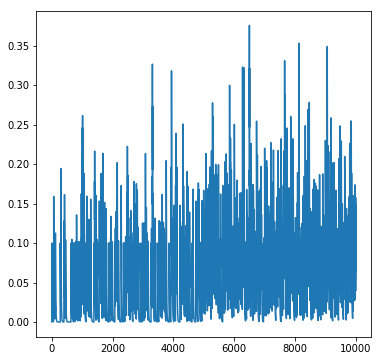

In [16]:
plt.figure(figsize=(6,6))
plt.plot(rewards)
plt.show()
plt.close()

In [21]:
sim.run(render=True, num_steps=num_steps)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


0.0

In [17]:
print(0,list(model.predict(preprocess_state(0))[0]))
print(4,list(model.predict(preprocess_state(4))[0]))
print(8,list(model.predict(preprocess_state(8))[0]))
print(9,list(model.predict(preprocess_state(9))[0]))
print(10,list(model.predict(preprocess_state(10))[0]))
print(14,list(model.predict(preprocess_state(14))[0]))
print(1,list(model.predict(preprocess_state(1))[0]))

0 [0.046057798, 0.6044045, 0.2756686, 0.073869124]
4 [0.15945874, 0.30575353, 0.24215652, 0.29263118]
8 [0.24265422, 0.37171835, 0.29417503, 0.09145243]
9 [0.29222652, 0.24710278, 0.3545671, 0.10610358]
10 [0.18644679, 0.38950312, 0.2818531, 0.14219709]
14 [0.043434843, 0.69890046, 0.2234128, 0.034251872]
1 [0.17688642, 0.34662563, 0.3175382, 0.15894973]


In [18]:
print(model.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(16, 4) dtype=float32, numpy=
array([[-7.50055790e-01,  7.20536888e-01,  2.99758971e-01,
        -1.31807357e-01],
       [ 6.83390796e-02, -3.62677425e-01, -8.60581324e-02,
         1.07269846e-01],
       [ 7.31709063e-01,  6.96409792e-02,  6.47686958e-01,
         3.21905047e-01],
       [ 5.84448278e-01, -1.32299304e-01,  7.94271827e-02,
        -9.35545489e-02],
       [-3.74304950e-02, -4.90190297e-01, -3.59118849e-01,
         7.15548038e-01],
       [-4.45021719e-01,  3.12506914e-01,  8.14208984e-02,
        -2.17563689e-01],
       [-1.47783279e-01, -7.24689364e-02, -2.29998201e-01,
         7.67334580e-01],
       [-5.38394213e-01,  1.72553122e-01,  3.96567464e-01,
         8.76903534e-04],
       [ 5.86676180e-01, -9.05787870e-02,  3.97261418e-02,
        -2.43291765e-01],
       [ 6.75281763e-01, -5.96197009e-01,  1.29162654e-01,
        -1.91981077e-01],
       [ 2.63132274e-01, -1.03895687e-01, -6.31150380e-02,
         1.38051227e-01]

In [15]:
#loss test
p = np.zeros((1,3,2), np.float32)+0.85
a = np.zeros((1,3,2), np.float32)
a[0,:,0] = 1
r = np.zeros((1,3), np.float32)
r[0,-1] = 1

l = discrete_policy_loss(p,a,r)

print(l)

tf.Tensor(0.4875567, shape=(), dtype=float32)
